In [ ]:
!pip install geemap cartopy

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random

from os import listdir, mkdir
from os.path import join, exists
import datetime

import matplotlib.pyplot as plt

import ee
import geemap

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import Point

import warnings

warnings.filterwarnings('ignore')


In [7]:
ee.Authenticate()
ee.Initialize()

- Data: https://drive.google.com/drive/folders/1Ox4YX5Y4GASvoEQFoVEMpr1kxweSIqkS?usp=sharing

In [12]:
df = pd.read_csv('/content/drive/My Drive/Medium/WF/fire_archive_M-C61_466007.csv')
df = df[(df.confidence>70)&(df.type==0)]
df2 = pd.read_csv('/content/drive/My Drive/Medium/WF/fire_nrt_M-C61_466007.csv')
df2 = df2[(df2.confidence>70)]
df = pd.concat([df[['latitude',	'longitude', 'acq_date']], df2[['latitude',	'longitude', 'acq_date']]])
df

,latitude,longitude,acq_date
3,55.44560,-2.08140,2017-04-04
4,55.44360,-2.10100,2017-04-04
20,56.74640,-3.14430,2017-04-06
31,51.83090,-3.41170,2017-04-07
34,54.76060,-1.92250,2017-04-08
...,...,...,...
512,56.91247,-2.80033,2023-10-03
523,52.95260,-0.11241,2023-10-29
524,52.94933,-0.09505,2023-10-29
525,52.95766,-0.10552,2023-10-29


<Axes: >

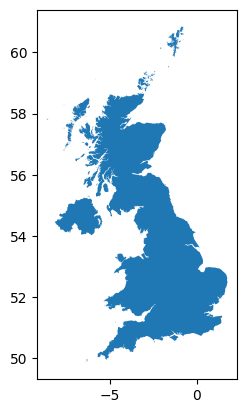

In [15]:
shape = gpd.read_file('/content/drive/My Drive/Medium/WF/gadm41_GBR_0.shp')
shape.plot()

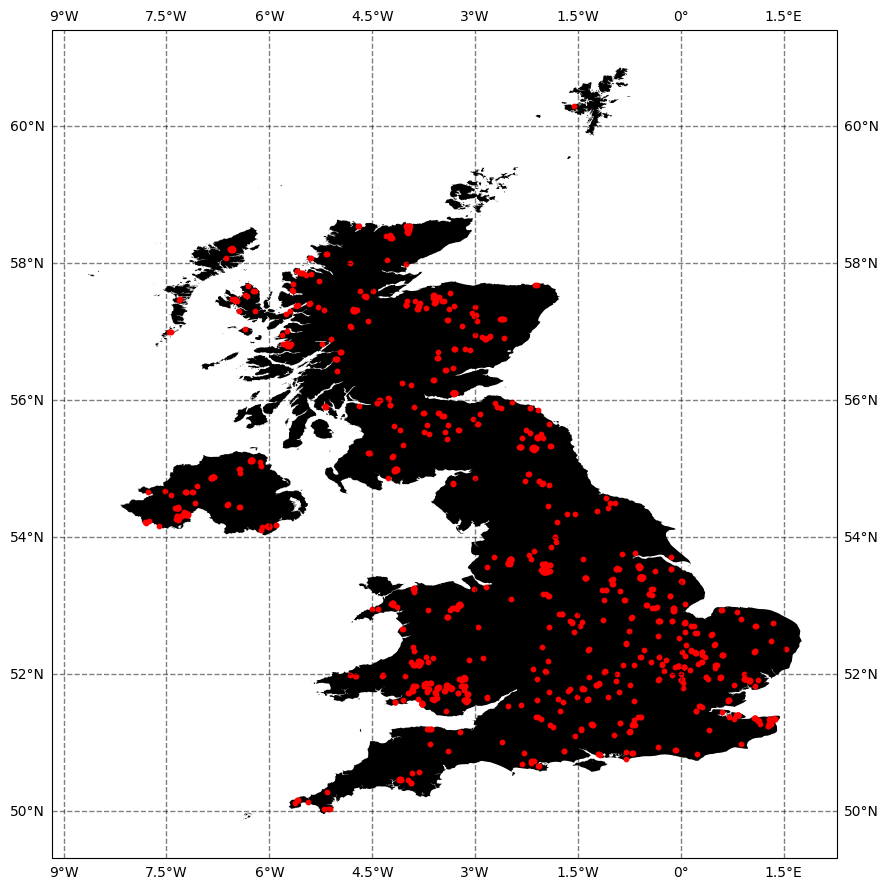

In [16]:
df['geometry'] = df.apply(lambda x: Point(x['longitude'],x['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df.reset_index(drop=True))

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 9))

shape.geometry.plot(ax=ax, color='black')
gdf.geometry.plot(ax=ax, color='red', markersize=10)

ax.gridlines(draw_labels=True,linewidth=1, alpha=0.5, linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [17]:
uk = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM0_NAME', 'U.K. of Great Britain and Northern Ireland'))
SBands = ['B2', 'B3','B4', 'B11','B12', 'SCL', 'QA60']

In [18]:
points = []
for i in range(len(df)):
    points.append(ee.Geometry.Point([df.longitude.values[i], df.latitude.values[i]]))

In [ ]:
dates = []
for i in range(len(df)):
    startDate = pd.to_datetime(df.acq_date.values[i])
    endDate = startDate+datetime.timedelta(days=1)
    S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                .filterBounds(points[i].buffer(2500).bounds())\
                .select(SBands)
    if S2.size().getInfo()!=0:
        S2_list = S2.toList(S2.size())
        for j in range(S2_list.size().getInfo()):
            img = ee.Image(S2_list.get(j)).select(SBands[:5])
            img = img.reproject('EPSG:4326', scale=10, crsTransform=None)
            roi = points[i].buffer(2500).bounds()
            array = ee.data.computePixels({
              'expression': img.clip(roi),
              'fileFormat': 'NUMPY_NDARRAY'
            })

            dates.append(startDate)
            np.save(join('./S2',f'{i}_{j}.npy'), array)
            print(f'Index: {i}/{len(df)-1}\tDate: {startDate}')
print('Done')

Map(center=[50, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
def img_vis(file, type='RGB', gamma=1.0):
    array = np.load(join('./S2',file))
    if type=='RGB':
        image = np.array([array['B4'][:, 192:694],array['B3'][:, 192:694],array['B2'][:, 192:694]])
        normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    elif type=='B11':
        image = np.array(array['B11'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))
    elif type=='B12':
        image = np.array(array['B12'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    corrected_image = np.power(normalized_image, gamma)
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

ax[0].imshow(img_vis('346_1.npy', 'RGB', 0.6))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img_vis('346_1.npy', 'B12'))
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [ ]:
files = listdir('./S2_img')
fig, ax = plt.subplots(4,3, figsize=(16,9))
for i in range(0,4):
    idx = random.randint(0, len(files)-1)

    ax[i,0].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'RGB', 0.8))
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B11'))
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

    ax[i,2].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B12'))
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

plt.tight_layout()
plt.show()